In [1]:
import torch
import os, yaml
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "../data/bbbc021_all"
metadata = "metadata"
metadata_file = "bbbc021_df_all.csv"
metadata_path = os.path.join(data_dir, metadata, metadata_file)
df = pd.read_csv(metadata_path)
df_train = df.loc[df["SPLIT"]=="train"].reset_index(drop=True)
df_test = df.loc[df["SPLIT"]=="test"].reset_index(drop=True)
df_train.head()

,Unnamed: 0.1,Unnamed: 0,SAMPLE_KEY,BATCH,TABLE_NUMBER,IMAGE_NUMBER,OBJECT_NUMBER,CPD_NAME,SMILES,DOSE,ANNOT,STATE,PLATE,SPLIT
0,0,0,Week1_22123_1_11_3.0,Week1_22123,1,11,3.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
1,1,1,Week1_22123_1_11_5.0,Week1_22123,1,11,5.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
2,2,2,Week1_22123_1_11_6.0,Week1_22123,1,11,6.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
3,3,3,Week1_22123_1_11_7.0,Week1_22123,1,11,7.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
4,4,4,Week1_22123_1_11_8.0,Week1_22123,1,11,8.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train


In [4]:
most_frequent_smiles = df['SMILES'].value_counts().idxmax()

# Create a dictionary of all values in SAMPLE_KEY corresponding to each DOSE for the identified SMILES
smiles_dose_dict = df[df['SMILES'] == most_frequent_smiles].groupby('DOSE')['SAMPLE_KEY'].apply(list).to_dict()
smiles_dose_dict.keys()

dict_keys([0.1, 0.3, 1.0, 3.0])

In [5]:
class ImageLoader:
    def __init__(self, meta_data, data_path):
        self.meta_data = meta_data
        self.data_path = data_path

    def __getitem__(self, sample_key):
        week, id_part, image_file = sample_key.split('_', 2)
        image_path = os.path.join(self.data_path, week, id_part, image_file + '.npy')
        assert os.path.exists(image_path), f"Image file {image_path} does not exist."
        # load image
        image = torch.from_numpy(np.load(image_path))
        image = torch.tensor(image, dtype=torch.float32)
        image = image.permute(2, 0, 1)  # Place channel dimension in front of the others
        return image

def convert_sample_keys_to_images(smiles_dose_dict, image_loader):
    images_dict = {}
    for dose, sample_keys in smiles_dose_dict.items():
        images_dict[dose] = [image_loader[sample_key] for sample_key in sample_keys]
    return images_dict

In [6]:
image_loader = ImageLoader(metadata_file, data_dir)

# Convert SAMPLE_KEY values to image tensors
images_dict = convert_sample_keys_to_images(smiles_dose_dict, image_loader)

/tmp/ipykernel_739174/2841628099.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


In [3]:
config_path = "../checkpoints/simCLR/simCLR_defaults/config.yaml"
model_chkpt_path = "../checkpoints/simCLR/simCLR_defaults/best_val.pt"

with open(config_path, "r") as file:
    config = yaml.safe_load(file)

model_chkpt = torch.load(model_chkpt_path)
model_chkpt.keys()

dict_keys(['epoch', 'state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss'])

In [8]:
# instantiate the model
from models.simCLR import simCLRrn50
model = simCLRrn50(projection_dim=config["projection_dim"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Function to load the model state dict
def load_model_state_dict(model, state_dict):
    # Check if the state dict keys are prefixed with 'module.'
    if list(state_dict.keys())[0].startswith('module.'):
        # Create a new state dict without the 'module.' prefix
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[len('module.'):]] = v
        state_dict = new_state_dict
    
    # Load the state dict into the model
    model.load_state_dict(state_dict)

# Example usage
# model_chkpt = torch.load('path_to_checkpoint.pth', map_location='cpu')
load_model_state_dict(model, model_chkpt['state_dict'])


In [11]:
# Function to process images through the encoder
def process_images_through_encoder(smiles_dose_dict, model):
    processed_images_dict = {}
    for dose, image_tensors in smiles_dose_dict.items():
        processed_images_dict[dose] = []
        for image_tensor in image_tensors:
            # Move image tensor to cuda:0 device
            image_tensor = image_tensor.to(device)
            # Process image tensor through the encoder
            with torch.no_grad():  # Disable gradient calculation
                encoded_image = model.encoder(image_tensor.unsqueeze(0))  # Add batch dimension
            processed_images_dict[dose].append(encoded_image.squeeze(0))  # Remove batch dimension
    return processed_images_dict

# Example usage
processed_images_dict = process_images_through_encoder(images_dict, model)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


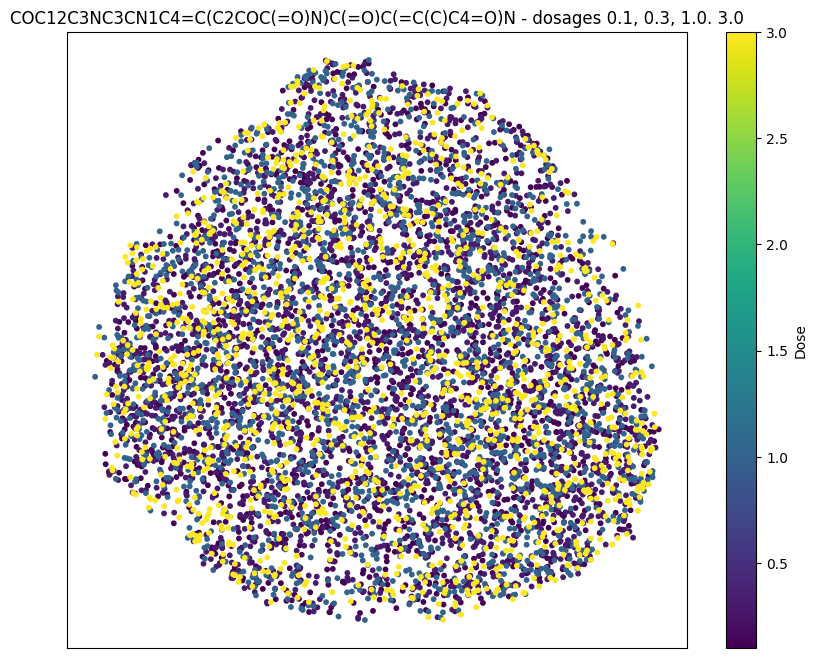

In [13]:
# Prepare data for UMAP
all_embeddings = []
all_doses = []
for dose, embeddings in processed_images_dict.items():
    for embedding in embeddings:
        all_embeddings.append(embedding.cpu().numpy().flatten())
        all_doses.append(dose)

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
all_doses = np.array(all_doses)

# Perform UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(all_embeddings)

# Plot the UMAP projections
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=all_doses, cmap='viridis', s=10)
plt.colorbar(scatter, label='Dose')
plt.title(f'{most_frequent_smiles} - dosages 0.1, 0.3, 1.0. 3.0')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()